# Matrix-Matrix Multiplikation
In diesem Beispiel wollen wir uns den Cannon-Algorithmus für die Matrix-Matrix Multiplikation in MPI ansehen. 

- [Topologien in MPI](#topo)
- [Idee des Algorithmus von Cannon mit Beispiel](#idee)
- [Implementierung](#impl)

## Topologien in MPI <a class="anchor" id="topo"></a>

Normalerweise sind die MPI Prozessoren in einer <span style="color:blue">**eindimensionalen Topologie**</span> angeordnet, d.H. jeder Prozess hat einen Rang von $0-N$. Jedoch gibt es Probleme, für deren Lösung Topologien der höheren Dimensionen hilfreich sein können, z.B. wenn ein Problem in mehrere Dimensionen aufgeteilt wird.

In Programmen, die diese Topologien benutzen sollen,  können die Prozessoren durch ihre Koordinaten in dieser Topologie identifiziert werden. 

Nehmen wir als Beispiel ein MPI Programm, in welchem die Prozesse in einer zweidimensionalen Topologie angeordnet sind. Wenn man eine 2-Dimensionale Topologie verwendet,  kann der Prozessor mit Koordinaten $(i,j)$ eine Nachricht an den Prozessor mit Koordinaten $(l,k)$ schicken. Damit ist es möglich, nicht nur Nachbarn "oben und unten" sondern auch "links und rechts" einfach zu definieren.

Um solche Programmen zu implementieren, müssen die Koordinaten der eindimentionalen Topologie auf die Koordinaten der zweidimensionalen Topologie abgebildet werden. Aus mehreren existierenden Abbildungsmöglichkeiten [[1]](#a) benutzen wir hier die, in der diese Abbildung <span style="color:blue">*reihenweise*</span> erfolgt. Wenn wir z.B. vier MPI Prozessoren mit Koordinaten <span style="color:blue">$1$</span>, <span style="color:green">$2$</span>, <span style="color:brown">$3$</span> und <span style="color:red">$4$</span> betrachten, die in einem Ring verbunden sind, können sie auf Prozessoren mit Koordinaten <span style="color:blue">$(0,0)$</span>, <span style="color:green">$(0,1)$</span>, <span style="color:brown">$(1,0)$</span>, <span style="color:red">$(1,1)$</span> abgebildet, die in einem Torus verbunden sind.

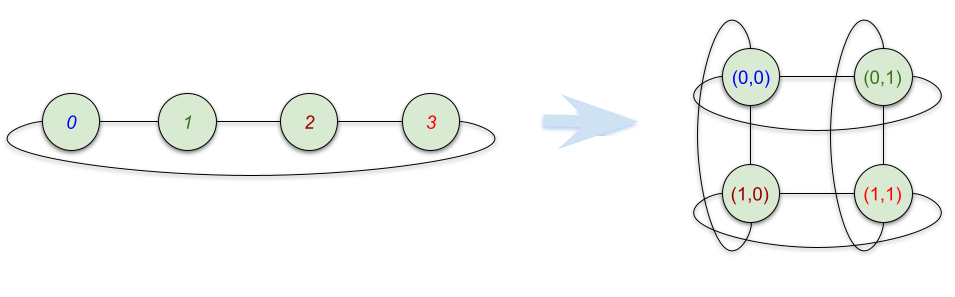

Einem Prozess mit Rang $r$ werden also die zweidimensionalen Koordinaten $(i,j)$ zugewiesen, wobei $i = r / 2$, $j = r \% 2$ und $2$ der Dimension der neuen Topologie entsprechen.

Die neue Koordinaten können mithilfe der MPI Funktion `MPI_Cart_Create` erzeugt werden. Das Interface dieser Funktion sieht wie folgt aus:

```C
MPI_Cart_Create(MPI_Comm comm_old, 
                int ndims, 
                int *dims, 
                int *periods, 
                int reorder, 
                MPI_Comm *comm_cart)
```

`MPI_Cart_Create` nimmt als Parameter eine Gruppe von Prozessoren, die zum Kommunikator `comm_old` gehören und bildet ihre Koordinaten auf eine neue Topologie ab, deren Informationen in `comm_cart` gespeichert sind. Jeder MPI Funktion, die diese neue Topologie benutzen möchte, muss der Kommunikator `comm_cart` als Argument weitergegeben werden. Die Eigenschaften der neuen Topologie sind in den Argumenten `ndims`, `dims` und `periods` spezifiziert. Das Argument `ndims` spezifiziert die Anzahl Dimensionen in der neuen Topologie. Das Array `dims` bestimmt die Größe entlang jeder Dimension. 
Das Array `periods` spezifiziert, ob die Topologie so genannte 'wraparound connections' hat. Insbesodere `periods[i] = true` bedeutet, dass die Topologie entlang der Dimension $i$ in einem Kreis verbunden sind. Das Argument `reoder` bestimmt, ob die Prozessoren im neuen Kommunikator `comm_cart` neue Ränge bekommen oder, ob die alte Ränge unverändert bleiben.

## Idee des Algorithmus von Cannon mit Beispiel <a class="anchor" id="idee"></a>

Seien $A,B \in \mathbb{R}^{n \times n}$ zwei quadratische Matrizen und $npes$ die Anzahl Prozessoren. Wir nehmen an, dass $npes$ eine Quadratzahl (d.h., dass es eine natürliche Zahl $s$ gibt, s.d. $s^2 = npes$ gilt) und $n$ eine vielfache von $\sqrt{npes}$ sind. Das Ziel ist, das Produkt $AB = C \in \mathbb{R}^{n \times n}$ zu berechnen. Die Eingabematrizen $A$ und $B$ werden auf die vorhandenen Prozessoren so verteilt, dass jeder Prozessor einen Matrixblock der Größe $n/s$ enthält. 

Als Beispiel betrachten wir zwei ${2 \times 2}$ Matrizen und $npes = 4$ Prozessoren. 

$A = \begin{pmatrix}
1 & 2\\
3 & 4
\end{pmatrix}
\text{ und }
B= \begin{pmatrix}
5 & 6\\
7 & 8
\end{pmatrix}
$

### Verfahren

**1. Sammlung der Informationen über den von MPI vorgegebenen Kommunikator und des aktuellen Prozessors.**

Dies kann wie immer mittels der folgenden MPI Funktionen erreicht werden

```C
MPI_Comm_size(comm, &npes);
MPI_Comm_rank(comm, &myrank);
```

**2. Erzeugung einer Kartesischen Topologie**

Nach der Ausführung von `MPI_Cart_create` werden den Prozessoren <span style="color:blue">$0$</span>, <span style="color:green">$1$</span>, <span style="color:brown">$2$</span>, <span style="color:red">$3$</span>. die folgende Koordinaten zugewiesen: <span style="color:blue">$(0,0)$</span>, <span style="color:green">$(0,1)$</span>, <span style="color:brown">$(1,0)$</span>, <span style="color:red">$(1,1)$</span>.

Wir nennen den Prozess mit Rang $(0,0)$ der <span style="color:blue">Wurzelprozess</span>. Er ist für die Initialisierung und Verteilung der Matrixelementen verantwortlich. Die Verteilung kann  z.B. durch `MPI_Bcast` erfolgen.

Danach hält **jeder Prozess $(i,j)$** Matrixblöcke von Matrizen $A$ und $B$ der Größe $1$ (also ein Element von Zeile $i$ von $A$ und $1$ Element von Spalte $j$ von $B$). Zur Berechnung des Produkts $c_{i,j} = \sum_{k=0}^n a_{i,k}b_{k,j}$, braucht er aber auch weitere Elemente von Matrizen $A$ und $B$. In unserem Beispiel hält z.B. der Prozess $(0,1)$ die Elemente $a_{0,1}=2$ und $b_{0,1}=6$, muss aber das Produkt $c_{0,1} = a_{0,0} \cdot b_{0,1} + a_{0,1}\cdot b_{1,1} = 1 \cdot 6 + 2 \cdot 8$ berechnen. 

Das Problem kann durch Kommunikation zwischen den Prozessoren gelöst werden. 

**3. Initiale Verschiebung von Eingabematrizen**

Initial werden die Elemente der Zeile $i$ von Matrix $A$ um $i$ nach links und die Elemente der Spalte $j$ von Matrix $B$ um $j$ nach unten rotiert.

Nach so eine Rotation sehen unsere Beispielmatrizen wie folgt aus:

$A = \begin{pmatrix}
1 & 2\\
4 & 3
\end{pmatrix}
\text{ und }
B= \begin{pmatrix}
5 & 8\\
7 & 6
\end{pmatrix}
$

Damit die Prozessoren nach der Umnummerirung Daten an ihren Nachbarn weiter geben können, müssen sie die Ränge der Nachbarn kennen. Diese Ränge können mithilfe von `MPI_Cart_shift` bestimmt werden. 

```C
MPI_Cart_shift(MPI_Comm comm_cart, 
               int dir,
               int s_step,
               int *rank_source,
               int *rank_dest)
```

Das Argument `dir` bestimmt, in welche Richtung die Daten verschickt werden sollen. `s_stept` gibt an, wie weit der Nachbar, an den die Daten verschickt werden sollen, von dem Senderknoten liegt. Die ausgerechneten Ränge werden in den Variablen `rank_source` und `rank_dest` gespeichert. Dabei wird in `rank_source`gespeichert, von wem man Daten empfängt (also von wem der Prozess selbst der rechte Nachbar ist) und an wen man Daten sendet (also z.B. den rechten Nachbarn)

Für die oben beschriebene Rotation können also die Ränge von Source- und Zielknoten wie folgt bestimmt werden. In dem folgenden Auschnitt werden die Nachbarn oben - und unten Bestimmt, welche für die Kommunikation in den Iterationen benätigt werden: 

```C
/* Berechne die Ränge rechts (Richtung 1, Step -1) und Unten (Richtung 0 und Step -1) */
MPI_Cart_shift(comm_2d, 1, -1, &rightrank, &leftrank);	//i. e. dim[1] is X-coord
MPI_Cart_shift(comm_2d, 0, -1, &downrank, &uprank);		//i. e. dim[0] is Y-coord
```

Die Ränge für die initiale  Verschiebung kann mithilfe des folgenden Befehls berechnet werden. In `-mycoords[0]` ist die lokale x-Koordinate in der lokalen Topoli gespeichert. Dies sorgt dafür, dass z.B. die Daten des Prozesses (1,0) um 1 nach rechts verschoben werden. 

```C
MPI_Cart_shift(comm_2d, 1, -mycoords[0], &shiftsource, &shiftdest);
```

**4. Hauptschleife: wiederhole $\sqrt{npes}$ Mal die folgende Schritte**

***Lokale Berechnungen***

Danach können die Prozessoren **lokal** die folgende Berechnungen durchführen.

* $(0,0)$: $1 \cdot 5=5$
* $(0,1)$: $2 \cdot 8=16$
* $(1,0)$: $4 \cdot 7 = 28$
* $(1,1)$: $3 \cdot 6=18$

***Kommunikation***

In jedem Schritt werden <span style="color:green">Matrixelemente von A ringförmig $\underline{nach \text{ } links}$ </span>
<span style="color:green"> Matrixelemente von B ringförmig $\underline{nach \text{ } oben}$ </span> kommuniziert. Die entsprechenden Prozesse haben wir oben schon berechnet.

In unserem Beispiel sehen die Matrizen nach dem 1. Kommunikationsschritt wie folgt aus:

$\begin{pmatrix}
2 & 1\\
3 & 4
\end{pmatrix}
\begin{pmatrix}
7 & 6\\
5 & 8
\end{pmatrix}$

In unserem Beispiel führen die Prozessoren also noch folgende lokale Berechnungen durch

* $(0,0)$: $5+2 \cdot 7=19$
* $(0,1)$: $16+1 \cdot 6=22$
* $(1,0)$: $28+3 \cdot 5=43$
* $(1,1)$: $18+4 \cdot 8=50$

und erhalten als **Ergebnis**

$\begin{pmatrix}
19 & 22\\
43 & 50
\end{pmatrix}
$

## Implementierung <a class="anchor" id="impl"></a>

Nun wollen wir den Algorithmus vollständig implementieren. 
Zunächst müssen die Header eingebunden werden.

In [1]:
#include <math.h>
#include <stdio.h>
#include <stdlib.h>
#include <mpi.h>
#include <sys/time.h>
#include <stdlib.h>
#include <cstdio>
 #include <unistd.h>
//Abkürzung für die Überprüfung, ob der aktuelle Prozess der Wurzelprozess ist
#define IS_ROOT (rank == 0)	

#define PRINTSIZELIMIT 11
//#define DEBUG 

In [2]:

void init_matrix(double **A_out, int n, int m, bool zeroM){
    int m_size = n*m;
    const size_t bytes = m_size*sizeof(double); 
    *A_out = (double*)malloc(bytes);
    
    for(int i=0; i<m_size; i++){
        if(zeroM){
            (*A_out)[i]=0;
        }else{
            (*A_out)[i]=rand()%100;
        }
        
    }
};



In [3]:
/** Implementiert die sequenzielle Version der Matrix-Matrix Multiplikation 
* @param n die Anzahl Elemente pro Matrixblock. n muss eine Quadratzahl sein. 
* @param *a, *b Verweise auf die Eingabematrizen 
* @param *c Verweis auf die Ausgabematrizen**/
void MatrixMultiply(int n, double *a, double *b, double *c) {
    for (int i = 0; i < n; i++)
        for (int j = 0; j < n; j++)
            for (int k = 0; k < n; k++)
                c[i * n + j] += a[i * n + k] * b[k * n + j];
}


In [4]:
bool isSquare(int x) {
	const float sqr = sqrtf(x);
	return (floor(sqr) == ceil(sqr));
}

Wie immer werden die Matrizen im Speicher zeilenweise linealisiert. Das besondere an der unten vorgestellten Implementierung ist, dass **jede Zeile einem Matrixblock entspricht**. 

Zum Beispiel wird die folgende Matrix (bei der Blockgröße $2$)  
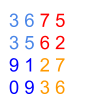

als folgende Array gespeichert:  
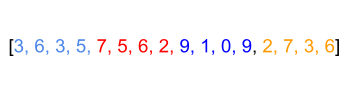

Diese Umrechnung kann mithilfe der Funktion ['getLinearAddress'](help_cannon.h) durchgeführt werden.

**Hinweis**: In dieser Aufgabe wird die Funktion `MPI_Sendrecv_replace`verwendet, welche nicht im Skript vorgestellt wird. Die Synthax dieser Funktion ist :
```C
int MPI_Sendrecv_replace(void *buf, 
                         int count, 
                         MPI_Datatype datatype,
                         int dest, 
                         int sendtag, int source, int recvtag,
                         MPI_Comm comm, MPI_Status * status)
```
Diese Funktion Sendet und emfpängt Daten im gleichen Puffer (`buf`), das heisst, die alten Daten werden überschrieben. Die Daten werden an `dest` geschickt und von `source` emfangen. Die Funktion sorgt dafür, dass es keinen Deadlock gibt und das die Daten in (`buf`) erst überschrieben werden, wenn sie von dem Sende-Teil nicht mehr benötigt werden.

In [5]:
/**
 * Implementiert Cannon Algorithmus für Multiplikation von zwei Matrizen.
 * @param n die Anzahl Elemente pro Matrixblock. n muss eine Quadratzahl sein.
 * @param *a, *b Verweise auf Blöcke der Eingabematrizen.
 * @param *c Verweise auf den Block der Ausgabematrix.
 * @param comm MPI_Communicator, der alle kommunizierenden Prozessoren beinhaltet.
 *
 * Bitte beachten Sie die Modifikation der initialen des Algorithmus (s. Grama et al.) 
 * Please observe the changes to the source code of Grama et al. for the initial matrix alignment and
 * the restoration of the original distribution. (The original code in the book leads to a deadlock.)
 */
void MatrixMatrixMultiply(int n, double *a, double *b, double *c, MPI_Comm comm) {
    int i;
    int nlocal;
    int npes, dims[2], periods[2];
    int myrank, my2drank, mycoords[2];
    int uprank, downrank, leftrank, rightrank;
    int shiftsource, shiftdest;
    MPI_Status status;
    //
    MPI_Comm comm_2d;

    /*Schritt 1: Sammlung der Informationen über den von MPI vorgegebenen Kommunikator 
      ================================================================================*/
    MPI_Comm_size(comm, &npes);
    MPI_Comm_rank(comm, &myrank);

    /*Schritt 2: Einrichtung einer Kartesischen Topologie 
      ===================================================*/
    dims[0] = dims[1] = sqrt(npes);
    periods[0] = periods[1] = 1;
    MPI_Cart_create(comm, 2, dims, periods, 1, &comm_2d);

    /* Bestimmung des Ranges und der Koordinaten bezüglich der neuen Topologie */
    MPI_Comm_rank(comm_2d, &my2drank);
    MPI_Cart_coords(comm_2d, my2drank, 2, mycoords);
    
     /*Schritt 3: Initiale Verschiebung
      =================================*/
    /* Berechnung der Ränge der Komminikationspartners links, rechts, oben und unten*/
    MPI_Cart_shift(comm_2d, 1, -1, &rightrank, &leftrank);	//i. e. dim[1] is X-coord
    MPI_Cart_shift(comm_2d, 0, -1, &downrank, &uprank);		//i. e. dim[0] is Y-coord

    /* Bestimmung der Größe von lokalen Matrizen*/
    nlocal = n / dims[0];

    #ifdef DEBUG
    if (1) {
        printf(
                "Process %d: my2drank: %d, "
                "mycoords[X]: %d, mycoords[Y]: %d, rightrank: %d, uprank: %d\n",
                my2drank, my2drank, mycoords[1], mycoords[0], rightrank, uprank);
    printf("Process mit Rang %d\n", myrank);
    printf("und Koordinaten %d, %d\n", mycoords[0], mycoords[1]);
    printf("Matrix A before alignment\n");
    print_matrix(a,nlocal,nlocal);
    printf("Matrix B before alignment\n");
    print_matrix(b,nlocal,nlocal);
    }
    #endif
    

    /* Durchführung der initialen Verschiebung für die Matrix A */
    MPI_Cart_shift(comm_2d, 1, -mycoords[0], &shiftsource, &shiftdest);
    //This is different to the solution from the book by GRAMA:
    //above we chose that dim[1] is X-coord (column)
    //Matrix A has to be shifted left according to the own Y-position
    #ifdef DEBUG
    if (1) {
    printf(
            "Process %d: Alignment for A  from %d --> %d; from %d --> %d;\n",
            myrank, my2drank, shiftdest, shiftsource, my2drank);
    }
    #endif

    MPI_Sendrecv_replace(a, nlocal * nlocal, MPI_DOUBLE, shiftdest, 1,
            shiftsource, 1, comm_2d, &status);

    /* Durchführung der initialen Verschiebung für die Matrix B */
    MPI_Cart_shift(comm_2d, 0, -mycoords[1], &shiftsource, &shiftdest);
    //This is different to the solution from the book by GRAMA:
    //above we chose that dim[0] is Y-coord (column)
    //Matrix B has to be shifted up according to the own X-position
    
    
    #ifdef DEBUG
    if (1) {
        printf("===========================================");
        printf("Process mit Rang %d\n", myrank);
        printf("und Koordinaten %d, %d\n", mycoords[0], mycoords[1]);
        printf("Matrix A after send and shift\n");
        print_matrix(a,nlocal,nlocal);
        printf("Matrix B after send and shift\n");
        print_matrix(b,nlocal,nlocal);

        printf(
                "Process %d: Alignment for B  from %d --> %d; from %d --> %d;\n",
                myrank, my2drank, shiftdest, shiftsource, my2drank);
        }
    #endif
    MPI_Sendrecv_replace(b, nlocal * nlocal, MPI_DOUBLE, shiftdest, 1,
            shiftsource, 1, comm_2d, &status);

    /* Hauptschleife */
    for (i = 0; i < dims[0]; i++) {
        
        /*Lokale Berechnungen
          -------------------*/
        MatrixMultiply(nlocal, a, b, c); /*c=c+a*b*/
        
        /*Kommunikation
          -------------*/
        /* Verschiebung der Matrix A um einen Block nach links */
        MPI_Sendrecv_replace(a, nlocal * nlocal, MPI_DOUBLE, leftrank, 1,
                rightrank, 1, comm_2d, &status);

        /* Verschiebung der Matrix B um einen Block nach oben */
        MPI_Sendrecv_replace(b, nlocal * nlocal, MPI_DOUBLE, uprank, 1,
                downrank, 1, comm_2d, &status);
         #ifdef DEBUG
        if (1) {
            printf("Process mit Rang %d\n", myrank);
            printf("und Koordinaten %d, %d\n", mycoords[0], mycoords[1]);
            printf("Matrix A\n");
            print_matrix(a,nlocal,nlocal);
            printf("Matrix B\n");
            print_matrix(b,nlocal,nlocal);
        }
        #endif
    }

    /* Herstellung der initialen Verteilung von Matrizen A und B */
    MPI_Cart_shift(comm_2d, 1, +mycoords[0], &shiftsource, &shiftdest);
    //again, this is different to the solution from the book by GRAMA:
    MPI_Sendrecv_replace(a, nlocal * nlocal, MPI_DOUBLE, shiftdest, 1,
                                       shiftsource, 1, comm_2d, &status);

    MPI_Cart_shift(comm_2d, 0, +mycoords[1], &shiftsource, &shiftdest);
    //again, this is different to the solution from the book by GRAMA:
    MPI_Sendrecv_replace(b, nlocal * nlocal, MPI_DOUBLE, shiftdest, 1,
            shiftsource, 1, comm_2d, &status);

    MPI_Comm_free(&comm_2d); 
}


In [6]:
%%executable cannon.x -- -lmpi

// start_main

int size, rank;
//Verweise auf die Ein- und Ausgabematrizen (allokiert beim Wurzelprozess)
double *matA, *matB; 
double *matC;
double *subMatA, *subMatB, *subMatC; 

int n = 576; //Teilbar durch 2,4, 9 und 16

MPI_Init(NULL, NULL);
MPI_Comm_size(MPI_COMM_WORLD, &size);
if (!isSquare(size)){
    printf("Fehlermeldung: Das Program soll mit eine quadratische Anzahl Prozessoren gestartet werden!\n");
    MPI_Abort(MPI_COMM_WORLD, 1);
}
// start_full
//Anzahl Matrixblöcke in die X-Richtung und die Y-Richtung
int tilesX; 
int tilesY;

//Anzahl Elemente pro Block in die X-Richtung
int tileSizeX; 	
int tileSizeY;

//Bestimme die Anzahl der Matrixblöcke
tilesX=sqrtf(size);	
tilesY = tilesX;

//Bestimme die Größe eines Matrixblocks
tileSizeX = n/tilesX; 
//TODO check if we really need it
tileSizeY = n/tilesY;
// start_init
MPI_Comm_rank(MPI_COMM_WORLD, &rank);
if(IS_ROOT){ 
    //Initialisierung
    
    init_matrix(&matA, n, n, false);
    init_matrix(&matB, n, n, false);
    init_matrix(&matC, n, n, true);
    
}

if(size > 1) 
{
//Allokierung der lokalen Matrizen 
   if(!(subMatA = (double*) malloc(tileSizeX*tileSizeX*sizeof(double)))){
       fprintf(stderr,"Prozessor %d: Speicherzuweisung für %d*%d doubles in Matrix subA ist fehlgeschlagen.\n", 
            rank, tileSizeX, tileSizeX);
    //Freigabe der bis jetzt allokierten Speicher
       if(IS_ROOT) {free(matA); free(matB), free(matC);}
       MPI_Abort(MPI_COMM_WORLD, 4);
  }
   if(!(subMatB = (double*) malloc(tileSizeX*tileSizeX*sizeof(double)))){
       fprintf(stderr,"Prozessor %d: Speicherzuweisung für %d*%d doubles in Matrix subB ist fehlgeschlagen.\n", rank, tileSizeX, tileSizeX);
      //Freigabe der bis jetzt allokierten Speicher
       if(IS_ROOT) {free(matA); free(matB), free(matC);}
       free(subMatA);
       MPI_Abort(MPI_COMM_WORLD, 5);
       MPI_Finalize();
       exit(5);
    }
    if(!(subMatC = (double*) malloc(tileSizeX*tileSizeX*sizeof(double)))){
        fprintf(stderr,"Prozessor %d: Speicherzuweisung für %d*%d doubles in Matrix subC ist fehlgeschlagen.\n", rank, tileSizeX, tileSizeX);
        //Freigabe der bis jetzt allokierten Speicher
        if(IS_ROOT) {free(matA); free(matB), free(matC);}
        free(subMatA);
        free(subMatB);
        MPI_Abort(MPI_COMM_WORLD, 6);
        MPI_Finalize();
        exit(6);
    }


//Verteilung der Matrix A 
    MPI_Scatter(matA, tileSizeX*tileSizeX, MPI_DOUBLE,
           subMatA, tileSizeX*tileSizeX, MPI_DOUBLE,
           0, MPI_COMM_WORLD);
//Verteilung der Matrix B
    MPI_Scatter(matB, tileSizeX*tileSizeX, MPI_DOUBLE,
           subMatB, tileSizeX*tileSizeX, MPI_DOUBLE,
           0, MPI_COMM_WORLD);

}
// end_init
// start_compute

if(size == 1) {
    MatrixMultiply(n, matA,matB, matC);
}
else {
    MatrixMatrixMultiply(tilesX*tileSizeX, subMatA, subMatB, subMatC, MPI_COMM_WORLD);

//Sammlung der Ergebnisse aller Prozessoren
    MPI_Gather(subMatC, tileSizeX*tileSizeX, MPI_DOUBLE,
        matC, tileSizeX*tileSizeX, MPI_DOUBLE,
        0, MPI_COMM_WORLD);
}
// end_compute
// end_full 
if(IS_ROOT){

    free(matA);
    free(matB);
    free(matC);
}
if(size>1) {
  free(subMatA);
  free(subMatB);
  free(subMatC);
}


MPI_Finalize();
// end_main

Writing executable to cannon.x


In [7]:
!mpiexec -np 4 ./cannon.x

[1] Grama A., Gupta A., Karypis G., Kumar V. (2003): Introduction to Parallel Computing. Addison Wesley.<a class="anchor" id="a"></a>

In [8]:
#include <performance.hpp>
performance p{"cannon.ipynb"};

In [9]:
display::lazy_image timingIm;

In [10]:
timingIm = p.display_timing({1,4,16},{576,576*2,576*4}, 2, "-O3", true);


Parameter sets (Current set: prob_size=2304, num_exec=16): 100%|██████████| 9/9 [02:28<00:00, 16.47s/it]


In [11]:
timingIm

<!DOCTYPE html>
 
 
 
 timing_plot0

In [12]:
timingIm = p.display_timing({1,4,9,16},{576,576*2,576*4}, 2, "-O3", false);
timingIm

Parameter sets (Current set: prob_size=2304, num_exec=16): 100%|██████████| 12/12 [02:38<00:00, 13.21s/it]


<!DOCTYPE html>
 
 
 
 timing_plot1